In [50]:
import pandas as pd
import numpy as np
import preprocessing
import re
import nltk

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing of Input Data

In [32]:
csv_file = 'data/reviews.csv'
preprocess = preprocessing.Preprocessing(csv_file, positive_num=5000, seed_num=8307)
df = preprocess.cleaning(stop_words='stopwords.txt')
# reserve this dataset for bert / RNN
preprocess2 = preprocessing.Preprocessing(csv_file, positive_num=5000, seed_num=8307)
df_original = preprocess2.cleaning(lowercase=True, remove_special=True, 
                                  stemming=False, stop_words=None)
df['orig_tokens'] = df_original['tokens'].copy()

Preprocessing the data
The sample size is:14791
Preprocessing the data
The sample size is:14791


In [34]:
df['y'] = df.sentiment.replace({'neutral': 0, 'positive': 1, 'negative': -1})
df.tail()

,Id,Review,Label,sentiment,tokens,orig_tokens,y
103995,103995,The lectures for this course seem unorganized ...,2,negative,lectur unorgan poor audio content cover lectur...,lectures course seem unorganized often poor au...,-1
88092,88092,This course was supposed to be the last one be...,1,negative,suppos capston huge amount network basic level...,course supposed last one capstone nothing huge...,-1
644,644,The lectures are just videos of the professor ...,1,negative,lectur video professor bloviat jefferson academ,lectures videos professor bloviating jefferson...,-1
19564,19564,An exceptional course with extremely well thou...,5,positive,except extrem thought inform cleverli laid mod...,exceptional course extremely well thought info...,1
63890,63890,The teacher is very kind and humorous. The who...,5,positive,teacher kind humor set video eleg gratitud,teacher kind humorous whole set video elegant ...,1


In [35]:
# somewhat balanced dataset after preprocessing
df['y'].value_counts()

 0    5071
 1    5000
-1    4720
Name: y, dtype: int64

In [42]:
# now that our data is balanced, let's split into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['tokens'], df['y'], 
                                                    test_size=0.1, 
                                                    stratify=df['y'],
                                                    random_state=8307)
print('value counts of y_train is :', y_train.value_counts())

value counts of y_train is :  0    4563
 1    4500
-1    4248
Name: y, dtype: int64


In [43]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(df['orig_tokens'], df['y'], 
                                                    test_size=0.1, 
                                                    stratify=df['y'],
                                                    random_state=8307)
print('value counts of y_train is :', y_train.value_counts())

value counts of y_train is :  0    4563
 1    4500
-1    4248
Name: y, dtype: int64


# Different Approaches of Sentiment Analysis
- tfidf with Naive Bayes
- tdidf with Other ML
- word2vec with normal neural network
- rnn
- cnn
- bert transformer

### (1) Naive Bayes with default countVectorizer

In [51]:
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize

# This is how the Naive Bayes classifier expects the input
def create_word_features(words):
    useful_words = word_tokenize(words)
    my_dict = dict([(word, True) for word in useful_words])
    return my_dict

train_NB = []
test_NB = []

for x, y in zip(X_train.tolist(), y_train.tolist()):
    train_NB.append((create_word_features(x), y))

for x, y in zip(X_test.tolist(), y_test.tolist()):
    test_NB.append((create_word_features(x), y))

classifier = NaiveBayesClassifier.train(train_NB)
accuracy = nltk.classify.util.accuracy(classifier, test_NB)
print(accuracy)

0.4702702702702703


### (2) Naive Bayes with tf-idf

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

# perform text processing before fitting
tfid = TfidfVectorizer()
tfid.fit(X_train)

X_train_tf = tfid.transform(X_train)
X_test_tf = tfid.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_tf.toarray(), y_train)
accuracy_score(y_test, clf.predict(X_test_tf.toarray()))

0.6297297297297297

NB with tf-idf is much much better than default countVectorizer

### (3) tf-idf with knn classifier

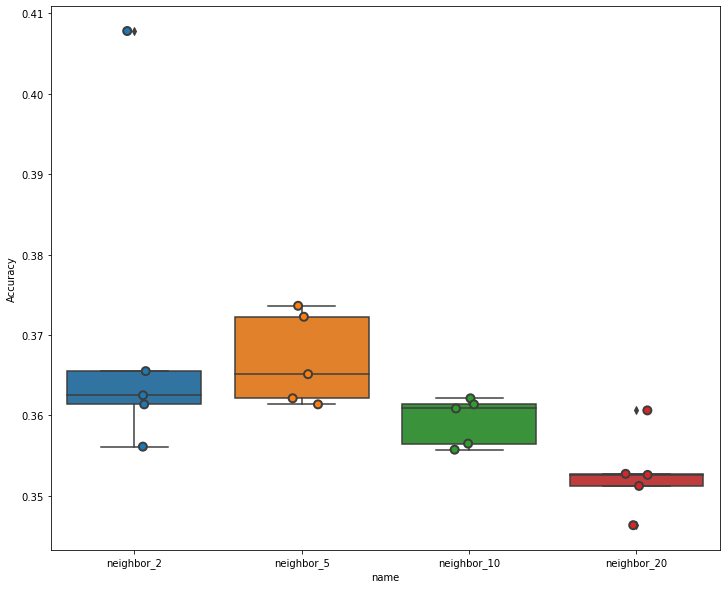

Final Accuracy: 0.3918918918918919


In [57]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = [2, 5, 10, 20]
knn_names = ['neighbor_{}'.format(n) for n in neighbors]
models = [KNeighborsClassifier(n_neighbors=n, p=2, metric='minkowski') for n in neighbors]

scores = []

for name, model in zip(knn_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), 
                                   y=y_train, cv=5, scoring='accuracy')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "Accuracy"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='Accuracy', data=cv_df)
sns.stripplot(x='name', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()

final_knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
final_knn.fit(X_train_tf.toarray(), y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_knn.predict(X_test_tf.toarray())))

KNN doesn't work well in this case

### (4) N-gram with logistic regression

C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

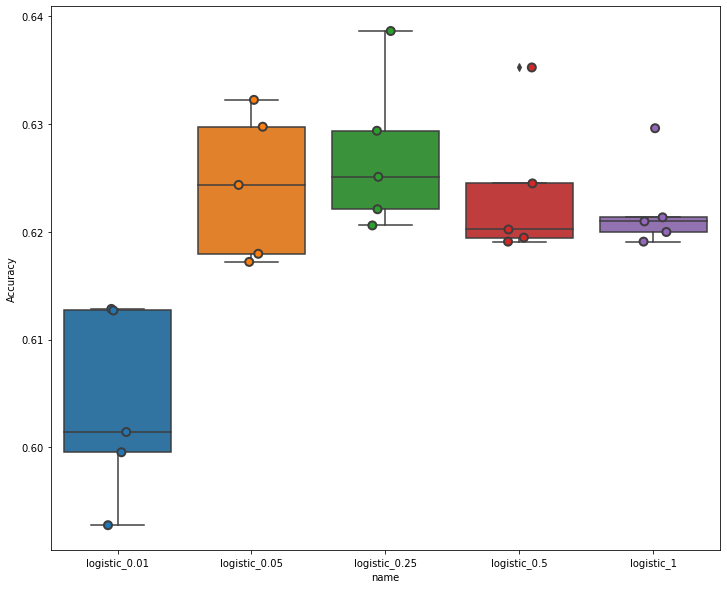

Final Accuracy: 0.6533783783783784


In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(X_train)
X_train_ngram = ngram_vectorizer.transform(X_train)
X_test_ngram = ngram_vectorizer.transform(X_test)

Cs = [0.01, 0.05, 0.25, 0.5, 1]
lr_names = ['logistic_{}'.format(c) for c in Cs]
models = [LogisticRegression(C=c) for c in Cs]

scores = []

for name, model in zip(lr_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_ngram, 
                                   y=y_train, cv=5, scoring='accuracy')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "Accuracy"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='Accuracy', data=cv_df)
sns.stripplot(x='name', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()
    
final_ngram = LogisticRegression(C=0.25)
final_ngram.fit(X_train_ngram, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_ngram.predict(X_test_ngram)))

Better than the previous algorithms

### (5) tf-idf with logistic regression

C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jordan.yew\anaconda3\envs\nlp\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

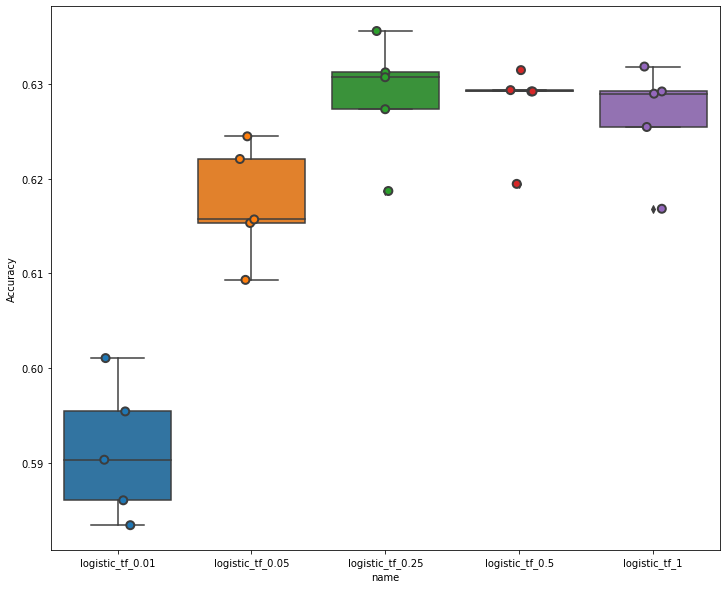

Final Accuracy: 0.654054054054054


In [55]:
from sklearn.linear_model import LogisticRegression

Cs = [0.01, 0.05, 0.25, 0.5, 1]
lr_names = ['logistic_tf_{}'.format(c) for c in Cs]
models = [LogisticRegression(C=c) for c in Cs]

scores = []

for name, model in zip(lr_names, models):
    model_name = name
    model_scores = cross_val_score(estimator=model, X=X_train_tf.toarray(), 
                                   y=y_train, cv=5, scoring='accuracy')
    for fold_idx, score in enumerate(model_scores):
        scores.append((model_name, fold_idx, score))

cv_df = pd.DataFrame(scores, columns=['name', "fold_idx", "Accuracy"])

fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(x='name', y='Accuracy', data=cv_df)
sns.stripplot(x='name', y='Accuracy', data=cv_df, size=8, jitter=True, edgecolor='gray', linewidth=2)
plt.show()
    
final_lr_tf = LogisticRegression(C=0.25)
final_lr_tf.fit(X_train_tf.toarray(), y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_lr_tf.predict(X_test_tf.toarray())))

Almost the same with ngram embedding

### (4) word2vec with CNN

In [56]:
y_train_onehot = pd.get_dummies(y_train)
y_test_onehot = pd.get_dummies(y_test)
y_test_onehot.tail()

,-1,0,1
1827,0,0,1
65762,0,0,1
49171,0,0,1
101213,1,0,0
30080,0,0,1


### (5) word2vec with RNN

### (6) BERT Transformer

In [ ]:
# USE this for BERT 
######## X_train_orig, X_test_orig, y_train, y_test ###########